# CIFAR-10 Image Classifier

I'm aware of the fact that Tensorflow provides a nicely formatted and cleaned version of the CIFAR-10 dataset using `cifar10.load_data()`. Simply using the data from this seems to provide a slightly better validation accuracy (~0.65-0.70) for some reason. But as I understand, data wrangling and cleaning is just as important as building and training the model, so I took the time to preprocess and normalize the raw dataset myself. 

# Import modules

In [17]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Convolution2D, Activation, Dropout, Dense
import numpy as np
import matplotlib.pyplot as plt
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data info

- **data**: The image data as Numpy arrays which are fed into a model (i.e. the x value). The data has dimensions 10,000x3,072, that is, 10,000 images with 32x32 pixels * 3 color channels (RGB)
- **labels**: The actual labels which the model must successfully classify (i.e. the y value)

# Load data

In [18]:
# Code for unpacking data, provided by the CIFAR-10 homepage
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batchNames = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

# Training set
xTrainRaw = np.empty((0,3072),int)
yTrainRaw = np.empty((0))
# Loop through the files and create one large training set
for name in batchNames:
    
    trainBatch = unpickle("../data/" + name)
    xTrainRaw = np.append(xTrainRaw, trainBatch[b'data'], axis=0)
    yTrainRaw = np.append(yTrainRaw, trainBatch[b'labels'], axis=0)

test = unpickle('../data/test_batch')
print(xTrainRaw.shape)

# Test set
xTestRaw = test[b'data']
yTestRaw = np.asarray(test[b'labels'])

(50000, 3072)


# Data transformation

The x data in its raw form, (50000,3072) for the training set (10000,3072) for the test set, is not suitable for feeding into a model.

For a CNN, we should convert the dimensions of each image from a simple row vector (3072) into (width,height,nChannels), which in our case is (32,32,3).

In [19]:
xTrain = xTrainRaw.reshape(50000, 32,32,3)
xTest = xTestRaw.reshape(10000,32,32,3)

yTrain = yTrainRaw
yTest = yTestRaw

# Data normalization

Scale the RGB values from 0-255 to 0.0-1.0 for the model. 

In [20]:
# Normalize data between 0 and 1
# Max-min normalization
xTrain= xTrain / 255.0
xTest = xTest / 255.0

# Build model

In [21]:
# Sequential CNN model
# I used the same architecture from https://www.tensorflow.org/tutorials/images/cnn
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

# Train model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xTrain, yTrain, epochs=10, 
                    validation_data=(xTest, yTest))

Epoch 1/12
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6180 - accuracy: 0.4159 - val_loss: 1.4084 - val_accuracy: 0.5007
Epoch 2/12
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3154 - accuracy: 0.5307 - val_loss: 1.2500 - val_accuracy: 0.5561
Epoch 3/12
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1914 - accuracy: 0.5777 - val_loss: 1.1763 - val_accuracy: 0.5855
Epoch 4/12
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0992 - accuracy: 0.6116 - val_loss: 1.1420 - val_accuracy: 0.5975
Epoch 5/12
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0334 - accuracy: 0.6355 - val_loss: 1.1968 - val_accuracy: 0.5774
Epoch 6/12
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9783 - accuracy: 0.6553 - val_loss: 1.1351 - val_accuracy: 0.6035
Epoch 7/12
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9327 - accuracy: 0.6720 - val_loss: 1.1096 - val_accuracy:

# Plot performance

Comment: The model seems to be overfitting - accuracy goes up to 0.80-0.95 while val accuracy stays at 0.60. 

313/313 - 0s - loss: 1.1270 - accuracy: 0.6254


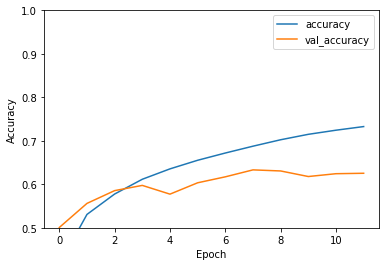

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("../plots/model-performance.png")
testLoss, testAcc = model.evaluate(xTest,  yTest, verbose=2)
